In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, norm

In [71]:
df = pd.read_excel("AB test Data 3 .xlsx")
df.head()

,BusinessKey,group_type,deliveries,clicks
0,41691743,1,38,27
1,34474972,1,28,23
2,26742819,1,37,23
3,48616788,1,20,19
4,16517052,1,39,18


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34497 entries, 0 to 34496
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   BusinessKey  34497 non-null  int64
 1   group_type   34497 non-null  int64
 2   deliveries   34497 non-null  int64
 3   clicks       34497 non-null  int64
dtypes: int64(4)
memory usage: 1.1 MB
None

Описательная статистика:
        BusinessKey    group_type    deliveries        clicks
count  3.449700e+04  34497.000000  34497.000000  34497.000000
mean   2.924867e+07      0.500884     12.441922      0.577847
std    1.207156e+07      0.500006      9.710035      1.225942
min    1.633269e+07      0.000000      0.000000      0.000000
25%    1.761521e+07      0.000000      4.000000      0.000000
50%    2.509726e+07      1.000000     11.000000      0.000000
75%    4.067854e+07      1.000000     19.000000      1.000000
max    5.063572e+07      1.000000     46.000000     27.000000

Рас

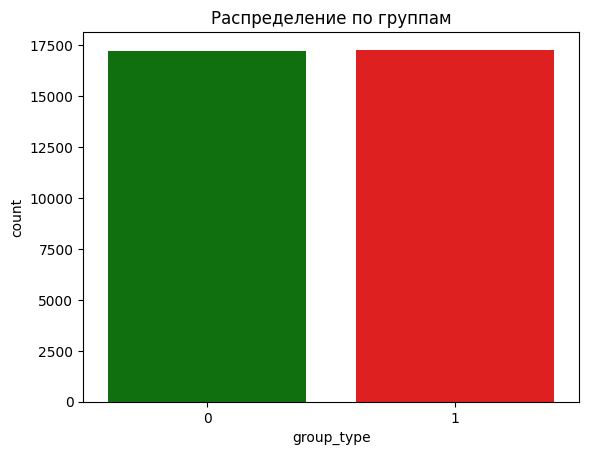


Пропущенные значения:
BusinessKey    0
group_type     0
deliveries     0
clicks         0
dtype: int64

Дубликатов по BusinessKey нет


In [72]:
print("Информация о данных:")
print(df.info())

print("\nОписательная статистика:")
print(df.describe())

print("\nРаспределение по группам:")
print(df['group_type'].value_counts())

sns.countplot(x='group_type', data=df, hue='group_type', palette=['green', 'red'], legend=False)
plt.title('Распределение по группам')
plt.show()

print("\nПропущенные значения:")
print(df.isnull().sum())

# Проверка наличия дубликатов в BusinessKey
if df['BusinessKey'].duplicated().any():
    print("\nДубликаты есть!")
else:
    print("\nДубликатов по BusinessKey нет")

In [73]:
print(df['group_type'].unique())
df['group_type'] = np.where(df['group_type']==0, 'B', 'A')
print(df['group_type'].unique())

[1 0]
['A' 'B']


In [74]:
# Количество нулевых deliveries и clicks по группам
print('Количество нулевых deliveries по группам:')
print(df[(df['deliveries']==0)]['group_type'].value_counts())
df = df[(df['deliveries']!=0)]
print('Количество нулевых deliveries после фильтрации:', len(df[(df['deliveries']==0)]))

# Количество нулевых clicks по группам
print('\nКоличество нулевых clicks по группам:')
print(df[(df['clicks']==0)]['group_type'].value_counts())

Количество нулевых deliveries по группам:
B    2598
A    2318
Name: group_type, dtype: int64
Количество нулевых deliveries после фильтрации: 0

Количество нулевых clicks по группам:
B    9813
A    9191
Name: group_type, dtype: int64


In [75]:
df['ctr'] = df['clicks'] / df['deliveries']

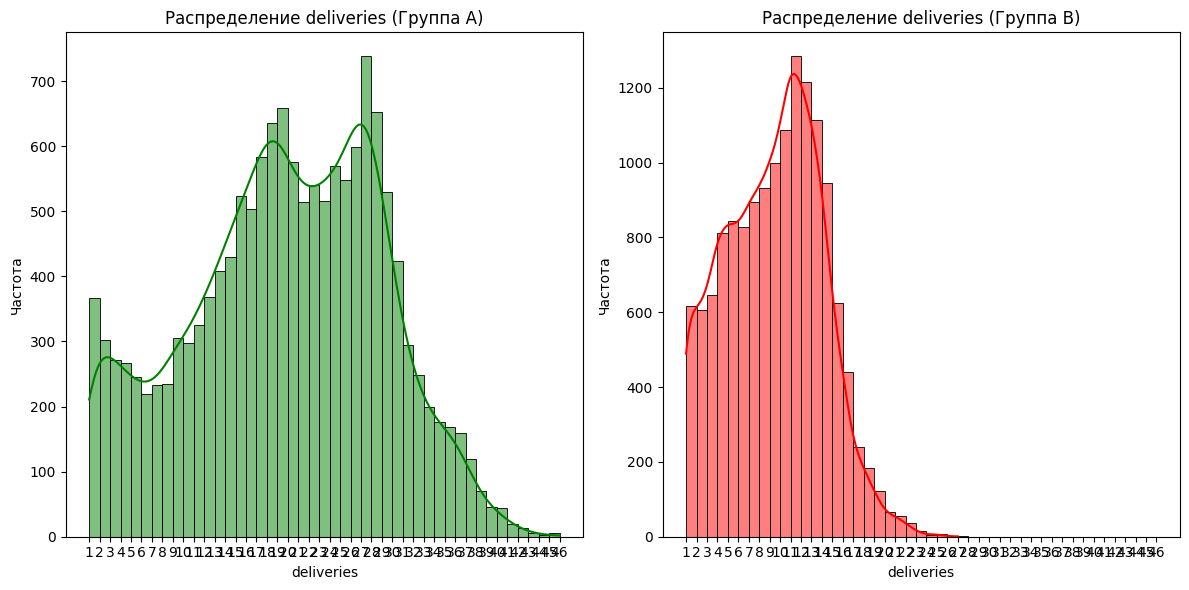

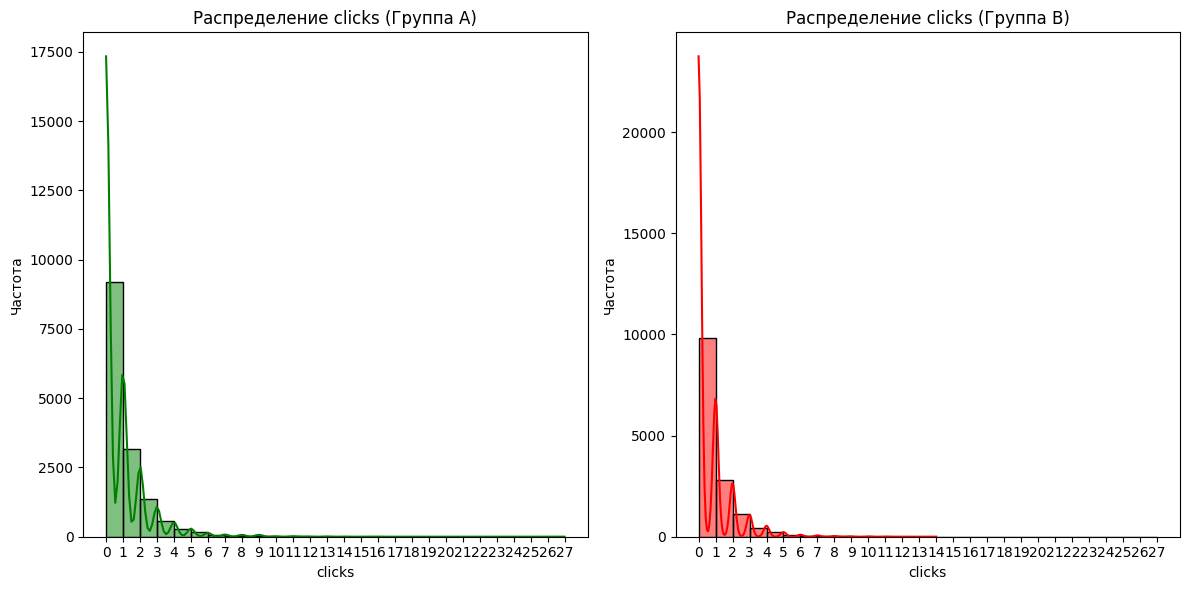

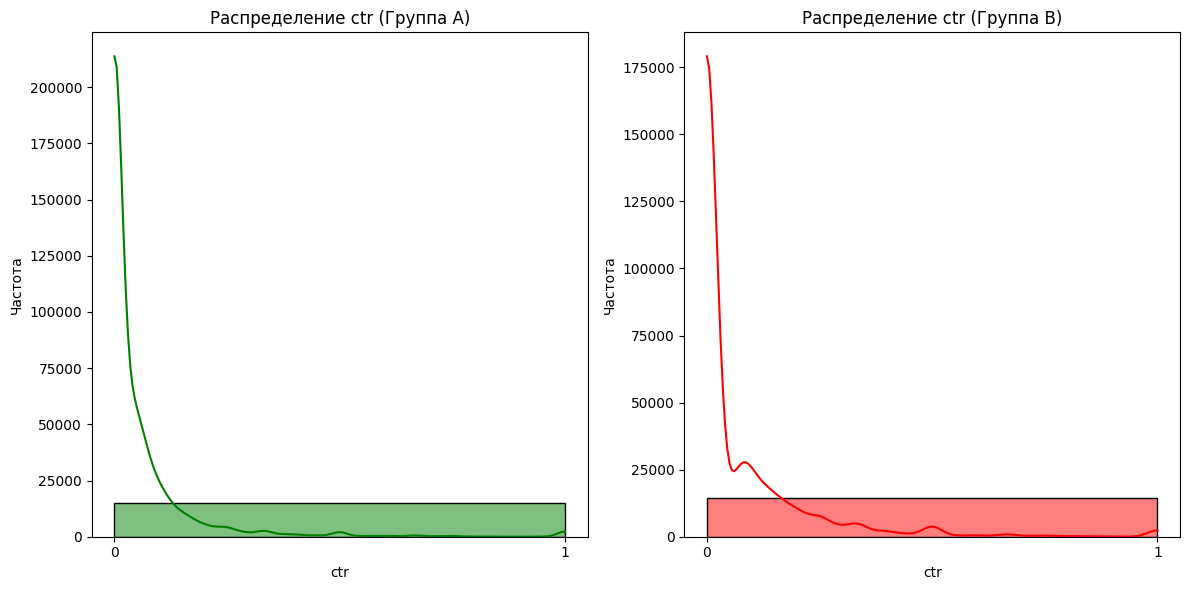

In [76]:
# Функция для построения распределений
def plot_distribution(column, title, color_a='green', color_b='red'):
    plt.figure(figsize=(12, 6))

    # Определяем границы оси X с шагом 1
    min_val = df[column].min()
    max_val = df[column].max()
    x_ticks = np.arange(min_val, max_val + 1, 1)

    # Гистограмма для группы A
    plt.subplot(1, 2, 1)
    sns.histplot(df[df['group_type'] == 'A'][column], color=color_a, kde=True, bins=x_ticks)
    plt.xticks(x_ticks)  # Устанавливаем шаг 1 по оси X
    plt.title(f'{title} (Группа A)')
    plt.xlabel(column)
    plt.ylabel('Частота')

    # Гистограмма для группы B
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['group_type'] == 'B'][column], color=color_b, kde=True, bins=x_ticks)
    plt.xticks(x_ticks)  # Устанавливаем шаг 1 по оси X
    plt.title(f'{title} (Группа B)')
    plt.xlabel(column)
    plt.ylabel('Частота')

    plt.tight_layout()
    plt.show()

# Построение распределений
plot_distribution('deliveries', 'Распределение deliveries')
plot_distribution('clicks', 'Распределение clicks')
plot_distribution('ctr', 'Распределение ctr')

In [77]:
df_groupped = df.groupby('group_type').agg(
    size=("group_type", "count"),
    deliveries=("deliveries", "sum"),
    clicks=("clicks", "sum")
).reset_index()

df_groupped['ctr'] = round(df_groupped['clicks']/df_groupped['deliveries']*100,2)
print(df_groupped)

  group_type   size  deliveries  clicks   ctr
0          A  14961      292938   11389  3.89
1          B  14620      136271    8545  6.27


In [78]:
# Функция для удаления выбросов с использованием IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # 1-й квартиль (25-й процентиль)
    Q3 = df[column].quantile(0.75)  # 3-й квартиль (75-й процентиль)
    IQR = Q3 - Q1  # Межквартильный размах
    
    # Определяем границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем данные, оставляя только те, которые находятся в пределах границ
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_cleaned

df = remove_outliers(df, 'deliveries')
df = remove_outliers(df, 'clicks')

# Переопределим ctr после удаления выбросов
df['ctr'] = df['clicks'] / df['deliveries']

In [81]:
# Разделяем данные на две группы: A и B
group_A = df[df['group_type'] == 'A']['ctr']
group_B = df[df['group_type'] == 'B']['ctr']

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(group_A, group_B)

print(f"Статистика теста Манна-Уитни: {stat}")
print(f"p-значение: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимая разница между группами A и B.")
else:
    print("Нет статистически значимой разницы между группами A и B.")

Статистика теста Манна-Уитни: 92363860.0
p-значение: 0.016953879828562418
Есть статистически значимая разница между группами A и B.


In [82]:
# Расчет MDE
p = 0.04  # Текущий CTR
alpha = 0.05  # Уровень значимости
beta = 0.1 # Мощность теста (1 - β)
n = 136271  # Размер выборки для одной группы

# Z-значения
z_alpha = norm.ppf(1 - alpha / 2)
z_beta = norm.ppf(1 - beta)

# Расчет MDE
mde = (z_alpha + z_beta) * np.sqrt((p * (1 - p)) / n) * 2

# Преобразуем MDE в процентное изменение
mde_percent = mde * 100

print(f"MDE: {mde_percent:.2f}%")

MDE: 0.34%
